In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [3]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [4]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [5]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [7]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [8]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

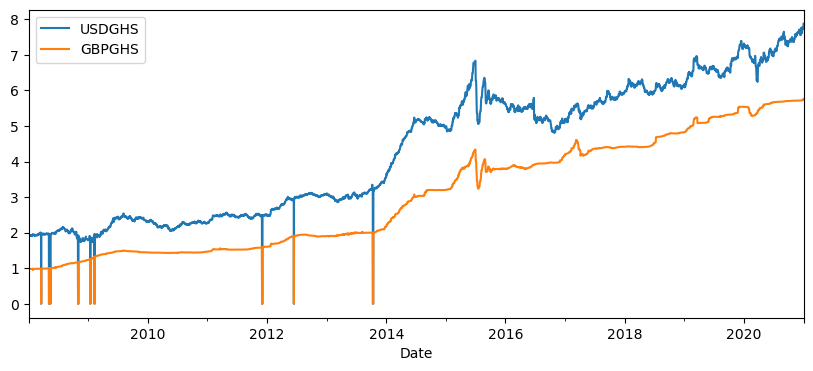

In [9]:
# Let's see a historical view of the closing price
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

In [10]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['USDGHS'].rolling(window=ma).mean()


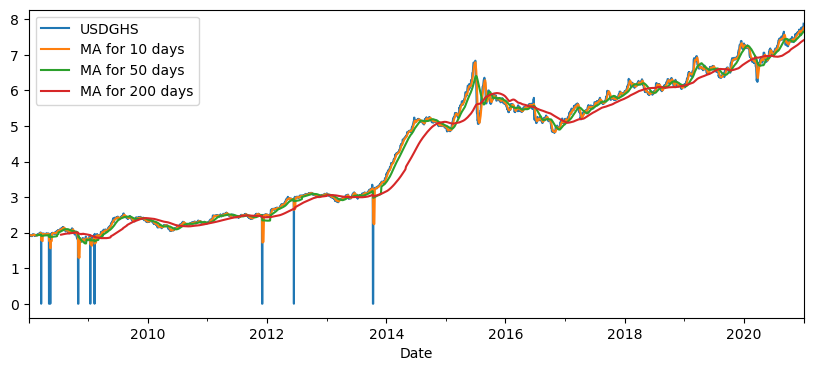

In [11]:
df_plot = df_plot[['USDGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(10,4))

In [12]:
USDGHS = df['USDGHS']
USDGHS.isnull().sum(),df.isnull().sum()

(0,
 USDGHS    0
 GBPGHS    0
 dtype: int64)

In [13]:
# df_diff = df_diff.dropna()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


In [14]:
df.shape

(4748, 2)

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

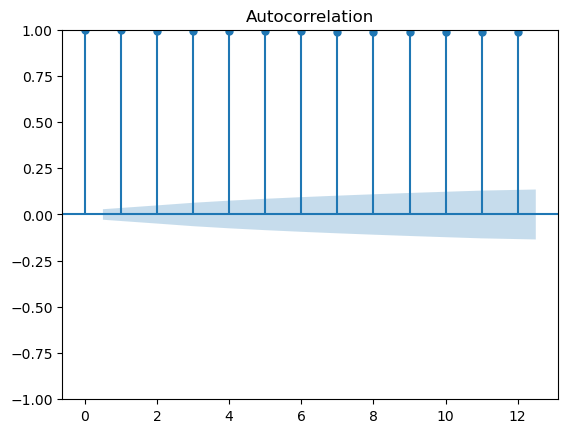

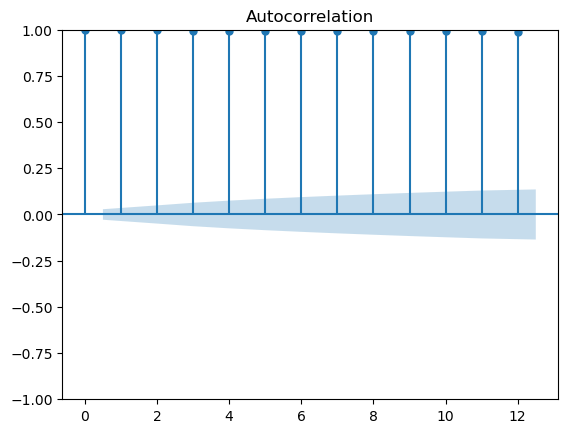

In [15]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df["USDGHS"], lags=12)
fig = tsaplots.plot_acf(df["GBPGHS"], lags=12)
plt.show()

In [16]:
print('the shape of the predicting dataset is ', df.shape)

the shape of the predicting dataset is  (4748, 2)


### Normalizing the data

We will normalize our data to values between 0 and 1 using the python's MinMaxScaler function. 

In [17]:
def normaliser(data,frange =(0,1)):
    #normaliser feutures
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    #dt = dt.reshape(-1,1)
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [18]:
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(df.values)
#prices_n = scaler2.fit_transform(stock_dataset[:].values)
normalised_prices[0:5] #Taking a look at our normalized values
# n = scaler2.fit_transform(USDGHS)

array([[0.24657621, 0.17003002],
       [0.24615736, 0.17003002],
       [0.2450785 , 0.17001267],
       [0.2450785 , 0.17001267],
       [0.2450785 , 0.17001267]])

### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [19]:
import numpy as np

def Model_data_setup(data, lookback, delay, min_index, max_index):
    """
    data:     Shape (n_samples, n_features). First column is the time series, other columns are the features.
    lookback: Number of time steps in the Model >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x, y) of numpy arrays where x is in shape (n_samples, n_timesteps, n_features) and 
             y is in shape (n_samples, delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    """
    n_samples = max_index - lookback - delay + 1
    x_shape = (n_samples, lookback, data.shape[1])
    x = np.zeros(x_shape)
    y_shape = (n_samples, delay)
    y = np.zeros(y_shape)

    for i in range(n_samples):
        start_index = i + min_index
        end_index = start_index + lookback
        x[i,:,:] = data[start_index:end_index,:]
        y[i,:] = data[end_index + delay - 1, 0]

    return x, y


In [20]:
xdata, ydata = Model_data_setup(normalised_prices, lookback=5, delay=1, min_index=0, max_index=df.shape[0]-1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [21]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2845, 5, 2)
The shape of the validation sample is:  (948, 5, 2)
The shape of the testing sample is:  (949, 5, 2)
The shape of the training target is:  (2845, 1)
The shape of the validation target is:  (948, 1)
The shape of the testing target is:  (949, 1)


In [22]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xvalid = np.reshape(xvalid, (xvalid.shape[0], xvalid.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))


## Neural Networks Models

In [23]:
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM,GRU,Conv1D, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam


The RNNs have a feedback mechanism that allows them to take into account the previous inputs in the sequence while making predictions. This feedback loop creates a kind of memory within the network, which is why RNNs are well-suited for sequential data. The mathematical representation of an RNN is:

\begin{equation}
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
\end{equation}

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $W_{hh}$ is the weight matrix for the hidden-to-hidden connections, $W_{xh}$ is the weight matrix for the input-to-hidden connections, $b_h$ is the bias term, and $f$ is an activation function.



LSTM networks are a type of RNN that are designed to address the vanishing gradient problem that can occur in traditional RNNs. LSTM networks use memory cells and gates to selectively remember or forget information from previous inputs. The mathematical representation of an LSTM network is:

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
\tilde{C}t &= \tanh(W_C \cdot [h{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align}

where $f_t$ is the forget gate, $i_t$ is the input gate, $o_t$ is the output gate, $\tilde{C}_t$ is the candidate cell state, $C_t$ is the cell state, and $h_t$ is the hidden state. $W_f$, $W_i$, $W_o$, and $W_C$ are the weight matrices, and $b_f$, $b_i$, $b_o$, and $b_C$ are the bias terms. $\sigma$ is the sigmoid activation function, and $\tanh$ is the hyperbolic tangent activation function.

Let's consider a sequence of two-dimensional data, represented as a tensor $X$ of shape $(num_timesteps, height, width, channels)$. At each time step $t$, the input $X[t]$ is processed by a ConvLSTM cell, which consists of several operations.

First, the cell applies a convolution operation to the input $X[t]$ and the previous hidden state $H[t-1]$, with a set of filters $W_x$ and $W_h$, respectively. The output of this convolution is a set of feature maps $F[t]$:

$$F[t] = \text{Conv}(X[t], W_x) + \text{Conv}(H[t-1], W_h)$$

Next, the cell applies several gating mechanisms to control the flow of information through the network. Specifically, it computes three gates: the input gate $i[t]$, the forget gate $f[t]$, and the output gate $o[t]$:

\begin{align*}
i[t] &= \sigma(\text{Conv}(X[t], W_i) + \text{Conv}(H[t-1], U_i)) \\
f[t] &= \sigma(\text{Conv}(X[t], W_f) + \text{Conv}(H[t-1], U_f)) \\
o[t] &= \sigma(\text{Conv}(X[t], W_o) + \text{Conv}(H[t-1], U_o))
\end{align*}

where $\sigma$ represents the sigmoid activation function, and $W_i$, $W_f$, $W_o$, $U_i$, $U_f$, and $U_o$ are the weights for the convolutional filters used to compute each gate.

These gates control which information is passed through the cell, and which information is discarded. The input gate $i[t]$ determines how much of the new input $F[t]$ is added to the memory cell $C[t]$, which stores the current state of the cell:

$$C[t] = i[t] \cdot \tanh(\text{Conv}(X[t], W_c) + \text{Conv}(H[t-1], U_c)) + f[t] \cdot C[t-1]$$

where $\tanh$ represents the hyperbolic tangent activation function, and $W_c$ and $U_c$ are the weights for the convolutional filters used to compute the cell state.

Finally, the output gate $o[t]$ determines the output of the cell:

$$H[t] = o[t] \cdot \tanh(C[t])$$

where $H[t]$ is the output of the cell at time ste

In [25]:
n_features = df.shape[1]
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64
lookback = 5

RNN model using the Sequential class from the `tf.keras.models` module. The model consists of three layers: an input layer, a SimpleRNN layer, and a Dense layer.

The Input layer specifies the shape of the input data, which is a 3D tensor with shape `(n_timesteps, n_features)` where `n_timesteps` is the number of time steps in each input sequence and n_features is the number of features in each time step.

The SimpleRNN layer is a type of RNN layer that uses the recurrent activation function tanh by default. It has 64 units and uses the `relu` activation function. This layer takes the input sequences as input and outputs a sequence of hidden states.

The Dense layer is a fully connected layer that takes the last hidden state from the SimpleRNN layer and outputs a single value, which is the predicted value for the next time step.

In [26]:
#define of RNN model
RNN = Sequential()
RNN.add(SimpleRNN(units, activation = 'tanh', 
                                  input_shape = (lookback, n_features), 
                                  return_sequences =False,recurrent_dropout=0.3))
\
RNN.add(Dense(1))
opt = Adam(lr)#, decay=1e-6)
RNN.compile(optimizer = 'Adam' , loss = 'mse', metrics=["mae"])
RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                304       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Define the LSTM model
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(32, activation='tanh',
                input_shape = (lookback,df.shape[1]),
                return_sequences = True))#,recurrent_dropout=0.3))


LSTM_Model.add(LSTM(32))
#model2.add(Dropout(0.5))
LSTM_Model.add(Dense(1))
opt = Adam(learning_rate=0.02)#, decay=1e-6)
LSTM_Model.compile(loss='mse', optimizer=opt , metrics=["mae"])
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [28]:
n_features =df.shape[1]
# define  of GRU model
GRU_Model = Sequential()
GRU_Model.add(GRU(128, activation='tanh', input_shape=(lookback, n_features)))
# GRU_Model.add(Dropout(0.1801))
GRU_Model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.0114)
GRU_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
GRU_Model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50688     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,817
Trainable params: 50,817
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Define MLP model
MLP_Model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(lookback,n_features,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

MLP_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
MLP_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5, 64)             192       
                                                                 
 dense_4 (Dense)             (None, 5, 32)             2080      
                                                                 
 dense_5 (Dense)             (None, 5, 1)              33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Define Conv1D model
conv1D_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(1)
])

conv1D_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
conv1D_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             224       
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 97        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


## Fitting All The Models

In [35]:
np.random.seed(123)
history_1=RNN.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=150, verbose=1)

Epoch 1/150
89/89 [==============================] - 1s 11ms/step - loss: 5.7273e-04 - mae: 0.0073 - val_loss: 1.0599e-04 - val_mae: 0.0095
Epoch 2/150
89/89 [==============================] - 1s 11ms/step - loss: 5.6978e-04 - mae: 0.0069 - val_loss: 6.3371e-05 - val_mae: 0.0070
Epoch 3/150
89/89 [==============================] - 1s 12ms/step - loss: 5.6220e-04 - mae: 0.0063 - val_loss: 6.3507e-05 - val_mae: 0.0070
Epoch 4/150
89/89 [==============================] - 1s 10ms/step - loss: 5.6304e-04 - mae: 0.0068 - val_loss: 2.0797e-04 - val_mae: 0.0138
Epoch 5/150
89/89 [==============================] - 2s 19ms/step - loss: 5.6438e-04 - mae: 0.0065 - val_loss: 2.3229e-05 - val_mae: 0.0035
Epoch 6/150
89/89 [==============================] - 1s 11ms/step - loss: 5.7750e-04 - mae: 0.0072 - val_loss: 2.6351e-05 - val_mae: 0.0037
Epoch 7/150
89/89 [==============================] - 1s 13ms/step - loss: 5.6038e-04 - mae: 0.0067 - val_loss: 2.4437e-05 - val_mae: 0.0036
Epoch 8/150
89/89 [=

In [36]:
RNN_df = pd.DataFrame(history_1.history)
RNN_df.tail()

,loss,mae,val_loss,val_mae
145,0.000537,0.006664,0.000040,0.005033
146,0.000562,0.007476,0.000052,0.005965
147,0.000548,0.006455,0.000023,0.003461
148,0.000550,0.006500,0.000040,0.005040
149,0.000549,0.006761,0.000072,0.007397


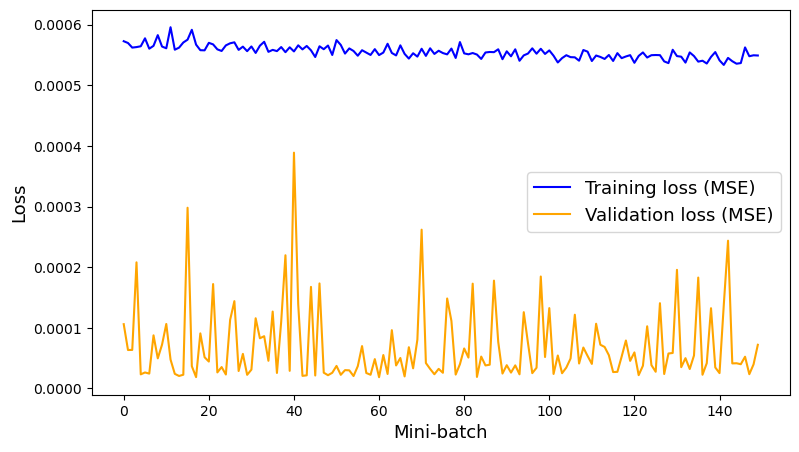

In [37]:
print('')
plt.figure(figsize=(9,5))
plt.plot(RNN_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(RNN_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

In [38]:
np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=150, verbose=1)

Epoch 1/150
89/89 [==============================] - 2s 23ms/step - loss: 4.0673e-04 - mae: 0.0077 - val_loss: 1.0230e-04 - val_mae: 0.0086
Epoch 2/150
89/89 [==============================] - 2s 24ms/step - loss: 3.9556e-04 - mae: 0.0073 - val_loss: 6.3179e-05 - val_mae: 0.0064
Epoch 3/150
89/89 [==============================] - 2s 25ms/step - loss: 4.1661e-04 - mae: 0.0080 - val_loss: 4.5278e-05 - val_mae: 0.0051
Epoch 4/150
89/89 [==============================] - 2s 22ms/step - loss: 3.9029e-04 - mae: 0.0071 - val_loss: 2.8759e-04 - val_mae: 0.0157
Epoch 5/150
89/89 [==============================] - 2s 20ms/step - loss: 3.7766e-04 - mae: 0.0063 - val_loss: 5.6578e-05 - val_mae: 0.0058
Epoch 6/150
89/89 [==============================] - 2s 24ms/step - loss: 4.1817e-04 - mae: 0.0086 - val_loss: 1.4318e-04 - val_mae: 0.0106
Epoch 7/150
89/89 [==============================] - 2s 23ms/step - loss: 3.8747e-04 - mae: 0.0067 - val_loss: 9.9110e-05 - val_mae: 0.0083
Epoch 8/150
89/89 [=

In [39]:
LSTM_df = pd.DataFrame(history_2.history)
LSTM_df.tail()

,loss,mae,val_loss,val_mae
145,0.000361,0.005748,0.000078,0.007493
146,0.000362,0.005842,0.000104,0.008943
147,0.000356,0.005668,0.000057,0.006125
148,0.000359,0.005914,0.000149,0.011240
149,0.000366,0.006190,0.000291,0.016329


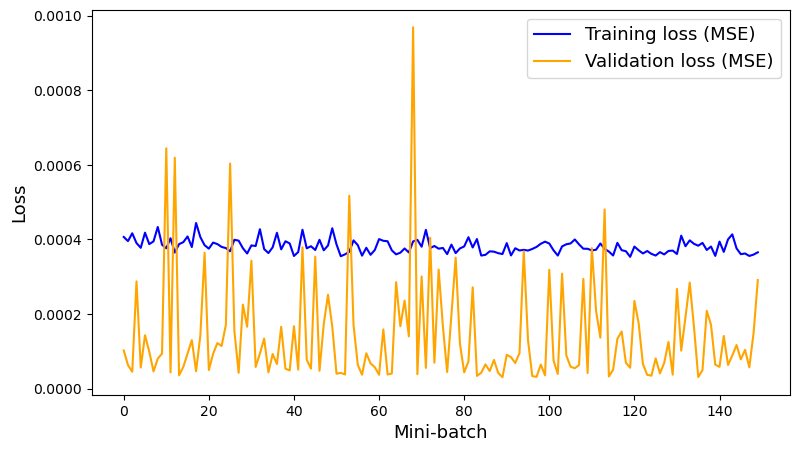

In [40]:
print('')
plt.figure(figsize=(9,5))
plt.plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/LSTM_error1.eps', format='eps', dpi=1000)
plt.show()

In [41]:
np.random.seed(123)
history_3=GRU_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=1)

Epoch 1/100
89/89 [==============================] - 11s 35ms/step - loss: 0.0045 - mae: 0.0319 - val_loss: 0.0042 - val_mae: 0.0620
Epoch 2/100
89/89 [==============================] - 1s 17ms/step - loss: 6.0747e-04 - mae: 0.0118 - val_loss: 0.0020 - val_mae: 0.0414
Epoch 3/100
89/89 [==============================] - 2s 19ms/step - loss: 5.6611e-04 - mae: 0.0098 - val_loss: 0.0020 - val_mae: 0.0422
Epoch 4/100
89/89 [==============================] - 2s 18ms/step - loss: 5.5217e-04 - mae: 0.0095 - val_loss: 0.0016 - val_mae: 0.0381
Epoch 5/100
89/89 [==============================] - 1s 16ms/step - loss: 5.3415e-04 - mae: 0.0092 - val_loss: 0.0013 - val_mae: 0.0342
Epoch 6/100
89/89 [==============================] - 2s 22ms/step - loss: 5.2842e-04 - mae: 0.0091 - val_loss: 2.8451e-04 - val_mae: 0.0147
Epoch 7/100
89/89 [==============================] - 2s 19ms/step - loss: 5.3714e-04 - mae: 0.0101 - val_loss: 1.2081e-04 - val_mae: 0.0094
Epoch 8/100
89/89 [========================

In [42]:
GRU_df =pd.DataFrame(history_3.history)
GRU_df.tail()

,loss,mae,val_loss,val_mae
95,0.000380,0.006041,0.000028,0.003836
96,0.000383,0.006212,0.000099,0.009000
97,0.000377,0.006364,0.000024,0.003577
98,0.000386,0.007010,0.000028,0.003898
99,0.000370,0.005588,0.000163,0.011923


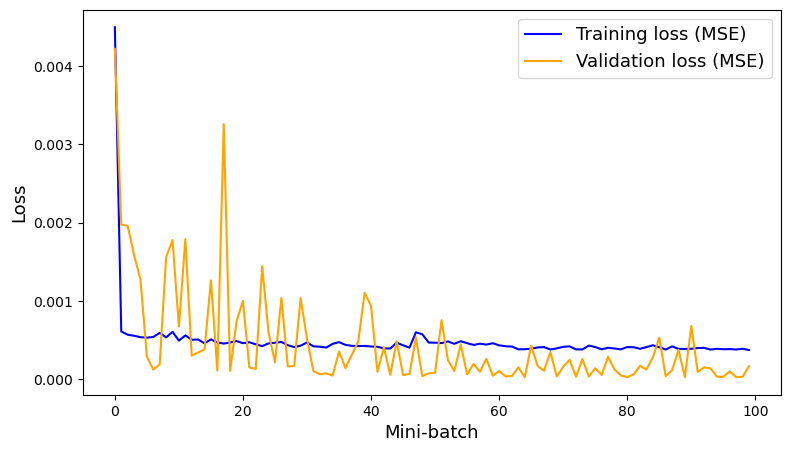

In [43]:
plt.figure(figsize=(9,5))
plt.plot(GRU_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(GRU_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU_error1.eps', format='eps', dpi=1000)
plt.show()

In [44]:
np.random.seed(123)
history_4 = MLP_Model.fit(xtrain, ytrain,
                          epochs=100,
                          validation_data=(xvalid, yvalid))

Epoch 1/100
89/89 [==============================] - 3s 13ms/step - loss: 0.0060 - mae: 0.0342 - val_loss: 0.0023 - val_mae: 0.0436
Epoch 2/100
89/89 [==============================] - 1s 7ms/step - loss: 6.9528e-04 - mae: 0.0112 - val_loss: 0.0025 - val_mae: 0.0463
Epoch 3/100
89/89 [==============================] - 1s 11ms/step - loss: 6.4218e-04 - mae: 0.0103 - val_loss: 0.0040 - val_mae: 0.0611
Epoch 4/100
89/89 [==============================] - 1s 8ms/step - loss: 6.4059e-04 - mae: 0.0105 - val_loss: 0.0032 - val_mae: 0.0546
Epoch 5/100
89/89 [==============================] - 2s 19ms/step - loss: 6.4392e-04 - mae: 0.0102 - val_loss: 0.0014 - val_mae: 0.0341
Epoch 6/100
89/89 [==============================] - 1s 15ms/step - loss: 6.1068e-04 - mae: 0.0090 - val_loss: 0.0019 - val_mae: 0.0408
Epoch 7/100
89/89 [==============================] - 1s 8ms/step - loss: 6.0709e-04 - mae: 0.0093 - val_loss: 0.0020 - val_mae: 0.0431
Epoch 8/100
89/89 [==============================] - 1s

In [45]:
MLP_Model =pd.DataFrame(history_4.history)
MLP_Model.tail()

,loss,mae,val_loss,val_mae
95,0.000583,0.008259,0.000431,0.019454
96,0.000572,0.007737,0.000585,0.023048
97,0.000604,0.009065,0.000490,0.020924
98,0.000577,0.008129,0.000230,0.013499
99,0.000606,0.008577,0.000562,0.022720


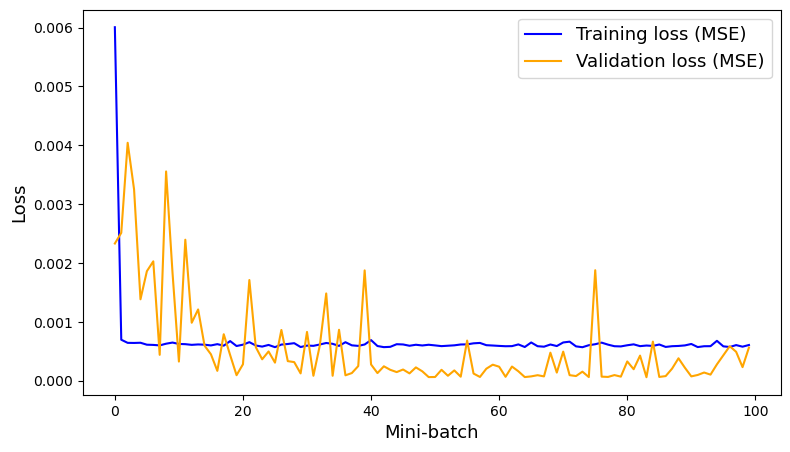

In [46]:
plt.figure(figsize=(9,5))
plt.plot(MLP_Model['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(MLP_Model['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/MLP_Model.eps', format='eps', dpi=1000)
plt.show()

In [47]:
np.random.seed(1)
history_5 = conv1D_Model.fit(xtrain,ytrain,batch_size=300,epochs=150,validation_data=(xvalid,yvalid), verbose = 1)


Epoch 1/150
10/10 [==============================] - 3s 77ms/step - loss: 0.0614 - mae: 0.2009 - val_loss: 0.0309 - val_mae: 0.1744
Epoch 2/150
10/10 [==============================] - 0s 17ms/step - loss: 0.0170 - mae: 0.1040 - val_loss: 0.0237 - val_mae: 0.1513
Epoch 3/150
10/10 [==============================] - 0s 16ms/step - loss: 0.0040 - mae: 0.0492 - val_loss: 0.0028 - val_mae: 0.0478
Epoch 4/150
10/10 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0213 - val_loss: 0.0015 - val_mae: 0.0339
Epoch 5/150
10/10 [==============================] - 0s 12ms/step - loss: 9.4760e-04 - mae: 0.0163 - val_loss: 0.0035 - val_mae: 0.0551
Epoch 6/150
10/10 [==============================] - 0s 13ms/step - loss: 8.2568e-04 - mae: 0.0131 - val_loss: 0.0023 - val_mae: 0.0441
Epoch 7/150
10/10 [==============================] - 0s 18ms/step - loss: 7.2263e-04 - mae: 0.0111 - val_loss: 0.0020 - val_mae: 0.0401
Epoch 8/150
10/10 [==============================] - 0s 18ms/ste

In [48]:
 conv1D_Model = pd.DataFrame(history_5.history)
 conv1D_Model.tail()

,loss,mae,val_loss,val_mae
145,0.000386,0.006319,0.000049,0.005430
146,0.000369,0.005154,0.000049,0.005460
147,0.000365,0.004826,0.000079,0.007446
148,0.000366,0.004736,0.000041,0.004726
149,0.000366,0.004560,0.000042,0.004890


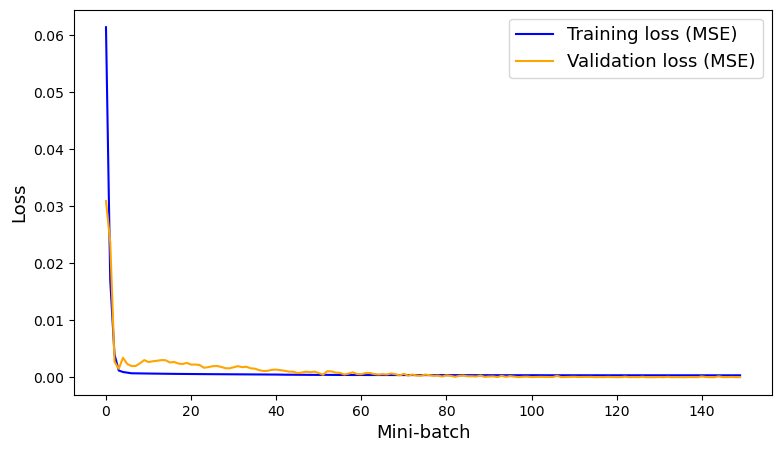

In [49]:
print('')
plt.figure(figsize=(9,5))
plt.plot(conv1D_Model['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(conv1D_Model['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/conv1D_Model.eps', format='eps', dpi=1000)
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_names = ['RNN', 'LSTM', 'GRU', 'MLP', 'Conv1D']  # list of model names
models = [RNN, LSTM_Model, GRU_Model, MLP_Model, conv1D_Model]  # list of models

mse = []
rmse = []
mae = []
r2 = []
mape = []
y_pred = []

for model in models:
    y_pred.append(model.predict(xtest))
y_pred = np.concatenate(y_pred)  # concatenate the arrays into a single array
mse.append(mean_squared_error(ytest, y_pred))
rmse.append(np.sqrt(mean_squared_error(ytest, y_pred)))
mae.append(mean_absolute_error(ytest, y_pred))
r2.append(r2_score(ytest, y_pred))
mape.append(np.mean(np.abs((ytest - y_pred) / ytest)) * 100)

results_df = pd.DataFrame({'Model': model_names, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape})


30/30 [==============================] - 0s 7ms/step


AttributeError: 'DataFrame' object has no attribute 'predict'

The RNN model had a test score of 0.0017 and the LSTM model had a test score of 0.0006. The lower test score indicates better performance, so the LSTM model performed better than the RNN model on this dataset.

In [ ]:
print('The the mean squared error committed by the standard MLP model is ', mean_squared_error(actual_values,predictions))
print('The squaroot of the mean squared error committed by the standard MLP model is ', np.sqrt(mean_squared_error(actual_values,predictions)))
print('The the mean absolute percentage error committed by the standard MLP model is: ', mean_absolute_percentage_error(actual_values,predictions))